# 1 Problem formulation

The problem I am trying to solve is to predict whether a hum or whistle audio file is in a major or minor key. Discerning the key of a song interpretation is interesting as it involves inferring relationships, or intervals, between musical notes from data in the frequency domain. In particular, major keys use the major third (4 semitones above the root/tonic of the key) and minor keys use the minor third (3 semitones above the root/tonic). If we know the tonic of a key, we should be able to infer whether the audio file is major or minor by which third is present.

The first issue for this problem is to extract musical notes from the audio signal. When produced by instruments, inferring notes from audio signals is relatively easy as instruments are likely in-tune and notes reliably relate to a given pitch. For hum and whistle song interpretations, the audio signal may not always exactly match the expected pitch and may be interpreted in a transposed key. A frequency band can be used to convert from frequency to musical notes whilst allowing for some inaccuracies.

Perhaps a larger problem is knowing the tonic of the key so the third can be identified. Any solution to this problem needs to infer the tonic before being able to classify audio files based upon the presence of major or minor thirds. My solution will need to incorporate assumptions for finding the tonic.

Nevertheless, song interpretations should retain enough structure of the original song to discern major from minor song. A solution to this problem could be applied to quickly tell users whether a song extract is major or minor, simply by humming or whistling the melody.

# 2 Machine Learning pipeline

__Input:__

The inputs of my pipeline are raw audio files from the MLEnd hums and whistles data set, consisting of a short segment from one of six songs, as interpreted by a participant in the MLEnd study. Of the six songs, three are in a major key (Singing in the Rain, Mamma Mia and Hakuna Matata) and three are in a minor key (Harry Potter theme, Imperial March and Pink Panther). For novel applications, the input of the pipeline would be hum or whistle interpretations of new or existing songs by a new interpreter.

__Intermediate stages:__

Feature extraction:

I will extract the percentage of time in each audio file during which the minor and major third are hummed or whistled. To do this I will generate a chromagram of each audio file, giving relative amplitudes of each musical note (A to G#) at each time. I assume the note being hummed/whistled at any given time is that with the largest amplitude. To extract the minor and major third, I assume that the note hummed or whistled most is the tonic of the key and extract the notes 3 and 4 semitones above the tonic.

Classification model:

A support vector machine, trained using a subset of all files from the MLEnd dataset, will classify the audio file using the percentage of time the minor (feature 1) and major (feature 2) thirds are hummed or whistled.


__Output:__

The output of my pipeline is a classification for each audio file in the input as either major or minor.


# 3 Transformation stage

__Chromagram:__

Input - raw audio file.

Output - chromagram.

A chromagram will be generated from a resampled time series of each audio file. This involves binning frequencies such that a relative amplitude is generated for each musical note (A through G#) at each time. The chromagram considers the same notes from different octaves equivalent. For instance, a middle C and high C are both considered 'C'.

__Percentage of Time Note is Hummed/Whistled:__

Input - chromagram.

Output - percentage of time each note is hummed or whistled.

Following this, I will extract the note with greatest relative amplitude at each time, making the assumption that this is the note being hummed or whistled. I will then total the counts for each note to get an estimate of how often each note is hummed or whistled during the audio file and divide by the total number of time bins to account for differences in length of recording.

__Assuming the Tonic:__

Input: percentage of time each note is hummed or whistled.

Output - percentage of time minor and major thirds are hummed or whistled.

To locate the major and minor thirds, I will assume that the tonic is the note hummed or whistled most often in each interpretation. I will then extract the percentage of the time during which the the minor and major thirds and hummed or whistled for each song interpretation. I will use these two percentages as features to train my models.

# 4 Modelling

__Support Vector Machine:__

A support vector machine (SVM) will be implemented to classify song interpretations into major and minor keys. A radial basis function (rbf) kernel will be used as interpretations are likely to be in two, perhaps overlapping, clusters with respect to the minor and major third features.*

__K-nearest neighbour:__

The K-nearest-neighbour classifier will predict that an interpretation is in a major key if the majority of training interpretations closest in latent feature space (Euclidean distance), to that of the test interpretation, are in a major key. Otherwise, the model will predict that the interpretation is in a minor key.

__Naive Bayes Classifier:__

A naive Bayes classifier will be trained on the major and minor third features to predict whether interpretations are major or minor. The distribution of songs in latent feature space for major and minor songs are assumed to be Gaussian.* Priors for each class will be generated from the training dataset and will be close to 0.5 as there are a near equal number of interpretations of major and minor songs in the training set.

\* Although this may not be strictly true, since interpretations for each song (e.g. Mamma Mia vs Hakuna Matata) may differ in features, it is expected that major songs will be grouped together in feature space, as will minor songs.

# 5 Methodology

For each model the following training and validation procedure will be carried out:

Models will be trained and validated using a subset of my dataset. The original dataset, consisting of all six songs, will be separated into a training set and a test set. 100 participants (out of 209) will be randomly selected and their audio files will be used for training and validation. The remaining 109 participants' data will be used as test data. The training dataset will further be divided into training and validation subsets, with a 70/30 split, through random selection.

This training and validation procedure will be repeated for each candidate value of K (1 $\le$ K $\le$ 15) in the K-nearest neighbour model. Default parameters (from the sklearn library) are used for the support vector machine and naive bayes classifier during validation.

Accuracy will be used as a quality metric for model performance during validation since I am interested in how often the model makes a correct prediction. There is no need to value the prediction of one class more than the other as correctly predicting major and minor is equally important.

To investigate whether prediction of major or minor is better than the other I will generate confusion matrices for each model. The percentage of correct predictions for actual major or minor interpretations (recall) will be used as a measure to compare how good the model is at predicting major versus minor.

The model with highest validation accuracy will be selected for use in the final pipeline and trained using the entire training dataset (all data from the selected 100 participants). The test accuracy and confusion matrix of the final model will then be calculated for the test dataset.

# 6 Dataset

The dataset I will use to train and validate my models is a subset of the MLEnd dataset, using only 6 songs, from 100 randomly sampled participants. Data from these 100 participants will be randomly split into training and validation sets.

## Import Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
from tqdm import tqdm

import librosa
import librosa.display

import re

In [ ]:
sample_path = 'C:/Users/taall/Documents/Postgrad/Machine_Learning/Mini_Project/all_data_adv/*.wav'

files = glob.glob(sample_path)
len(files)

2502

In [ ]:
MLEND_table = [] 
problem_names = []

for file in files:
    file_name = file.split('\\')[-1]

    # ppt ID
    find_ID = re.match('S[0-9]{1,3}', file_name)
    if find_ID:
        ppt_ID = find_ID.group(0)[1:]
    else:
        ppt_ID = 'unknown'
        problem_names.append(file_name)

    # interpretation type
    hum = re.search('h[a,u]m', file_name, re.IGNORECASE)
    whistle = re.search('whi', file_name, re.IGNORECASE)
    if hum:
        interpret_type = 'hum'
    elif whistle:
        interpret_type = 'whistle'
    else:
        interpret_type = 'unknown'
        problem_names.append(file_name)

    # interpretation number
    find_num = re.search('[^S0-9][0-9]', file_name)
    if find_num:
        interpret_num = find_num.group(0)[1]
    else:
        interpret_num = 'unknown'
        problem_names.append(file_name)

    # song
    potter = re.search('pot', file_name, re.IGNORECASE)
    starwars = re.search('sta', file_name, re.IGNORECASE)
    imperial = re.search('imp', file_name, re.IGNORECASE)
    panther = re.search('pan', file_name, re.IGNORECASE)
    rain = re.search('rai', file_name, re.IGNORECASE)
    hakuna = re.search('h[a,u]k', file_name, re.IGNORECASE)
    mamma = re.search('ma', file_name, re.IGNORECASE)
    if potter:
        song = 'Potter'
        key = 'minor'
    elif (bool(starwars) | bool(imperial)):
        song = 'StarWars'
        key = 'minor'
    elif panther:
        song = 'Panther'
        key = 'minor'
    elif rain:
        song = 'Rain'
        key = 'major'
    elif hakuna:
        song = 'Hakuna'
        key = 'major'
    elif mamma:
        song = 'Mamma'
        key = 'major'
    else:
        song = 'unknown'
        key = 'unknown'
        problem_names.append(file_name)

    MLEND_table.append([file_name, ppt_ID, interpret_type, interpret_num, song, key])

MLEND_table[:4]

[['S100_hum_1_Hakuna.wav', '100', 'hum', '1', 'Hakuna', 'major'],
 ['S100_hum_1_Potter.wav', '100', 'hum', '1', 'Potter', 'minor'],
 ['S100_hum_1_Rain.wav', '100', 'hum', '1', 'Rain', 'major'],
 ['S100_hum_2_Hakuna.wav', '100', 'hum', '2', 'Hakuna', 'major']]

In [ ]:
MLEND_df = pd.DataFrame(MLEND_table,columns=['file_id','participant','interpretation','number','song','key']).set_index('file_id') 
MLEND_df.participant = pd.to_numeric(MLEND_df.participant)
MLEND_df

,participant,interpretation,number,song,key
file_id,,,,,
S100_hum_1_Hakuna.wav,100,hum,1,Hakuna,major
S100_hum_1_Potter.wav,100,hum,1,Potter,minor
S100_hum_1_Rain.wav,100,hum,1,Rain,major
S100_hum_2_Hakuna.wav,100,hum,2,Hakuna,major
S100_hum_2_Mamma.wav,100,hum,2,Mamma,major
...,...,...,...,...,...
S9_hum_3_Mamma.wav,9,hum,3,Mamma,major
S9_hum_3_StarWars.wav,9,hum,3,StarWars,minor
S9_hum_4_Panther.wav,9,hum,4,Panther,minor


## Split Dataset into Training and Test

In [ ]:
MLEND_df.participant = pd.to_numeric(MLEND_df.participant)
selection = np.random.choice(range(1, max(MLEND_df.participant) + 1), 100, replace=False)
condition = [(i in selection) for i in MLEND_df.participant]
use_df = MLEND_df.loc[condition]
use_files = []
for file in files:
    file_name = file.split('\\')[-1]
    files_cond = any(use_df.index == file_name)
    if files_cond:
        use_files.append(file)

len(use_files)

1094

## Example Resampled Time Series from Audio File

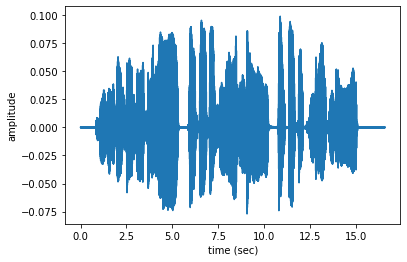

In [ ]:
fs = None
x, fs = librosa.load(files[20],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

The above graph shows amplitude over time for a single audio file.

## Example Chroma Frequencies

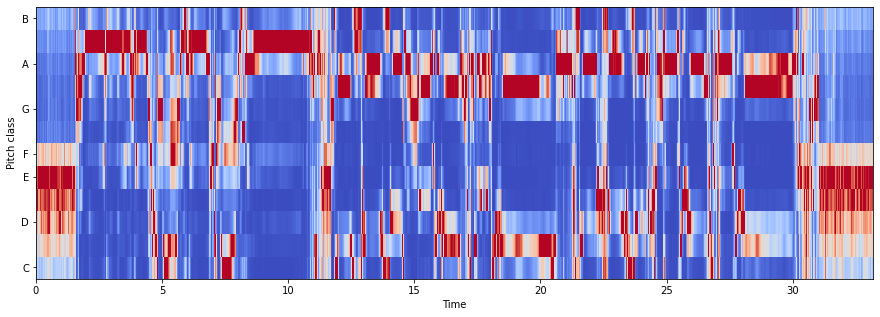

In [ ]:
x, fs = librosa.load(files[20],sr=fs)
hop_length = 512
chromagram = librosa.feature.chroma_stft(x, sr=fs, hop_length=hop_length)
plt.figure(figsize=(15, 5))
_ = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

The above graph shows a chromagram of a single audio file. Pitch class or note is shown on the y axis and time on the x axis. Red colour denotes high amplitude for frequencies in a given pitch class and blue denotes low amplitude.

## For How Long is Each Note Whistled/Hummed? 

For each note, the number of time bins in which the given note has a higher amplitude than all others is calculated.

In [ ]:
notes = np.bincount(np.argmax(chromagram, axis=0))
notes

array([ 63, 114,  71,  89, 157,  23,  11,  60, 226, 332, 246,  37],
      dtype=int64)

## Assuming the Tonic Note

The tonic is assumed to be the note which is hummed or whistled longest. The array is rearranged such that the tonic is in position 0, the minor third in position 3, and major third in position 4.

In [ ]:
notes_tonic = np.roll(notes, notes.size - notes.argmax())
notes_tonic

array([332, 246,  37,  63, 114,  71,  89, 157,  23,  11,  60, 226],
      dtype=int64)

## Normalising for Length of Recording
The number of time bins in which each note was hummed or whistled is divided by the total number of time bins in the time series, to account for differences in length of recording between audio files.

In [ ]:
notes_percent = notes_tonic / np.sum(notes_tonic)
notes_percent

array([0.2323303 , 0.17214836, 0.02589223, 0.04408677, 0.07977607,
       0.04968509, 0.06228132, 0.10986704, 0.01609517, 0.00769769,
       0.0419874 , 0.15815255])

## Visualising Percentage Time Hummed/Whistled for a Single Audio File

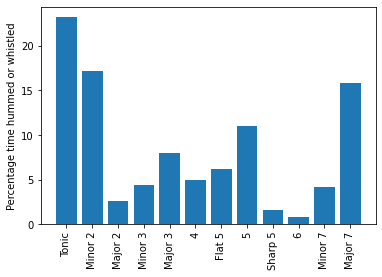

In [ ]:
plt.bar(['Tonic','Minor 2','Major 2','Minor 3','Major 3','4','Flat 5','5','Sharp 5','6','Minor 7','Major 7'],
        height = notes_percent * 100)
_ = plt.xticks(rotation=90)
_ = plt.ylabel('Percentage time hummed or whistled')

## Extract Chroma Frequencies

In [ ]:
def get_features(files, labels_file):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        yi = labels_file.loc[fileID, 'key']=='major'

        fs = None
        x, fs = librosa.load(file,sr=fs)
        hop_length = 512
        chromagram = librosa.feature.chroma_stft(x, sr=fs, hop_length=hop_length)
        notes = np.bincount(np.argmax(chromagram, axis=0), minlength=12)
        notes_tonic = np.roll(notes, notes.size - notes.argmax())
        notes_percent = notes_tonic / np.sum(notes_tonic)

        xi = notes_percent
        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

X, y = get_features(use_files, use_df)

100%|██████████████████████████████████████████████████████████████████████████████| 1148/1148 [04:05<00:00,  4.67it/s]


## Select Thirds from Features

In [ ]:
thirds = X[:,[3,4]]

## Visualise Major vs Minor Thirds from Training Data

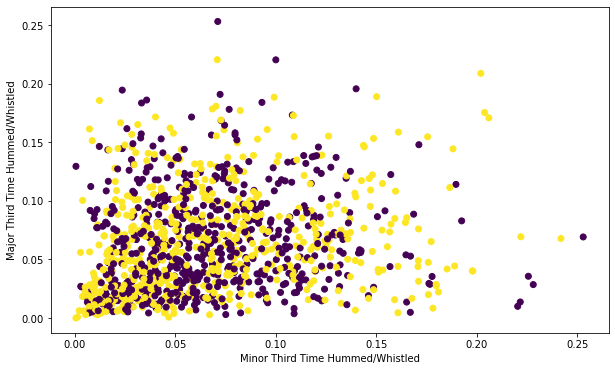

In [ ]:
# Plot 3D scatterplot
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = cm.get_cmap('viridis', 8)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
p = ax.scatter(X[:,3],X[:,4],c=y, cmap=cmap)
ax.set_xlabel('Minor Third Time Hummed/Whistled')
ax.set_ylabel('Major Third Time Hummed/Whistled')
plt.show()

The above graph shows percentage time hummed/whistled for minor versus major third. Each point shows a song interpretation, with interpretations of major songs shown in yellow and minor songs in purple. The major and minor third features seem not to distinguish minor and major songs well. Ideally we would see a split with major songs above the line x=y and minor songs below the line x=y. This will be discussed in the conclusion.

# 7 Results

## Train and Validate Models

### Split Training Data into Training and Validation Subsets

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(thirds,y,test_size=0.3)    # change test size
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((803, 2), (345, 2), (803,), (345,))

### Support Vector Machine

In [ ]:
from sklearn import svm

SVC  = svm.SVC()
SVC.fit(X_train,y_train)

yt_p = SVC.predict(X_train)
yv_p = SVC.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', SVC.support_vectors_.shape)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_val, y_pred=SVC.predict(X_val))
print('Validation recall for minor songs', conf_matrix[0,0] / np.sum(conf_matrix[0]))
print('Validation recall for major songs', conf_matrix[1,1] / np.sum(conf_matrix[1]))
pd.DataFrame(conf_matrix, columns = ['pred_minor', 'pred_major'], index = ['minor', 'major'])

Training Accuracy 0.5828144458281445
Validation  Accuracy 0.5739130434782609
The support vectors are (729, 2)
Validation recall for minor songs 0.7125748502994012
Validation recall for major songs 0.4438202247191011


,pred_minor,pred_major
minor,119,48
major,99,79


### K-Nearest Neighbour

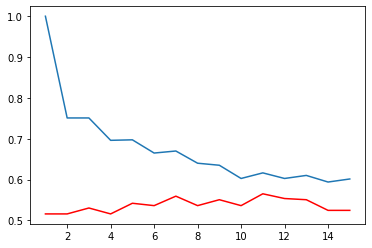

In [ ]:
from sklearn import neighbors

ks = range(1,16)

y_hat_t = dict.fromkeys(ks)
y_hat_v = dict.fromkeys(ks)
accuracy_t = dict.fromkeys(ks)
accuracy_v = dict.fromkeys(ks)
conf_mat_t = dict.fromkeys(ks)
conf_mat_v = dict.fromkeys(ks)

for k in ks:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_hat_t[k] = knn.predict(X_train)
    y_hat_v[k] = knn.predict(X_val)
    accuracy_t[k] = np.sum(y_train==y_hat_t[k])/len(y_train)
    accuracy_v[k] = np.sum(y_val==y_hat_v[k])/len(y_val)
    conf_mat_t[k] = confusion_matrix(y_true=y_train, y_pred=y_hat_t[k])
    conf_mat_v[k] = confusion_matrix(y_true=y_val, y_pred=y_hat_v[k])


figure, ax = plt.subplots(1, 1)
_ = ax.plot(ks, list(accuracy_t.values()))
_ = ax.plot(ks, list(accuracy_v.values()), c='red')

#### Select K = 7

Both K = 7 and K = 11 have some of the highest validation accuracies. K = 7 is selected to reduce the number of comparisons needed to classify songs.

In [ ]:
print('Training accuracy', accuracy_t[7])
print('Validation accuracy', accuracy_v[7])
print('Validation recall for minor songs', conf_mat_v[7][0,0] / np.sum(conf_mat_v[7][0]))
print('Validation recall for major songs', conf_mat_v[7][1,1] / np.sum(conf_mat_v[7][1]))
pd.DataFrame(conf_mat_v[7], columns = ['pred_minor', 'pred_major'], index = ['minor', 'major'])

Training accuracy 0.6699875466998755
Validation accuracy 0.5594202898550724
Validation recall for minor songs 0.6347305389221557
Validation recall for major songs 0.4887640449438202


,pred_minor,pred_major
minor,106,61
major,91,87


### Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

yt_p = gnb.predict(X_train)
yv_p = gnb.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

conf_matrix = confusion_matrix(y_true=y_val, y_pred=gnb.predict(X_val))
print('Validation recall for minor songs', conf_matrix[0,0] / np.sum(conf_matrix[0]))
print('Validation recall for major songs', conf_matrix[1,1] / np.sum(conf_matrix[1]))
pd.DataFrame(conf_matrix, columns = ['pred_minor', 'pred_major'], index = ['minor', 'major'])

Training Accuracy 0.5566625155666252
Validation  Accuracy 0.5333333333333333
Validation recall for minor songs 0.6646706586826348
Validation recall for major songs 0.4101123595505618


,pred_minor,pred_major
minor,111,56
major,105,73


## Model Selection

The support vector machine has the best validation accuracy (0.574) so will be used in the final machine learning pipeline.

## Test Final Model

In [ ]:
test_condition = [not (i in selection) for i in MLEND_df.participant]
test_df = MLEND_df.loc[test_condition]
test_files = []
for file in files:
    file_name = file.split('\\')[-1]
    files_cond = any(test_df.index == file_name)
    if files_cond:
        test_files.append(file)

len(test_files)

1408

In [ ]:
X_test, y_test = get_features(test_files, test_df)

100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [05:00<00:00,  4.69it/s]


In [ ]:
thirds_test = X_test[:,[3,4]]
ytest_p = SVC.predict(thirds_test)
print('Test Accuracy', np.mean(ytest_p==y_test))
conf_matrix = confusion_matrix(y_true=y_test, y_pred=ytest_p)
print('Test recall for minor songs', conf_matrix[0,0] / np.sum(conf_matrix[0]))
print('Test recall for major songs', conf_matrix[1,1] / np.sum(conf_matrix[1]))
pd.DataFrame(conf_matrix, columns = ['pred_minor', 'pred_major'], index = ['minor', 'major'])

Test Accuracy 0.5589488636363636
Test recall for minor songs 0.6860795454545454
Test recall for major songs 0.4318181818181818


,pred_minor,pred_major
minor,483,221
major,400,304


## Explaining Results

Three models were trained on the minor and major third features. These features represented the percentage of time during which the minor or major third note was hummed or whistled in a song interpretation. The model with highest validation accuracy was the support vector machine (57.4%), which was used in the final machine learning pipeline.

The final model's test accuracy was 55.9%, suggesting the model is not very good at discerning major from minor song interpretations. The test recall for minor songs (68.6%) was higher than that for major songs (43.2%), indicating that the model performs better when given an interpretation of a song in a minor key than in a major key.

# 8 Conclusions

My final model does not predict whether song interpretations are major or minor well, with a test accuracy close to 50% chance (test accuracy = 55.9%). One explanation for this is that the features that the model uses may not be suitable for classifying major and minor songs.

Major and minor thirds may have been extracted incorrectly for some song interpretations because the tonic is not the most hummed/whistled note in the audio file. The tonic is not always the most played note in a song's melody, so making this assumption when extracting thirds may have led to features which were not the true minor and major third of the song. Moreover, interpreters may not always have been humming or whistling in tune. With major and minor thirds only one semitone away from each other, the distinction may have been blurred when hums and whistles were at boundary frequencies between musical notes.

An alternative could be to keep the percentage of time hummed/whistled for all notes, without assuming which is the tonic, and use all 12 values as features. This may allow the model to distinguish songs based on the percentage of notes in each interpretation and perhaps discern major from minor in this way. Although this may be a more effective solution, with a training dataset which only includes three major and three minor songs, it is likely that models would overfit to these particular songs. A model such as this would likely not generalise well to predicting novel major or minor song interpretations, if trained on so few songs. A larger dataset, consisting of songs in many different major and minor keys (A minor, B minor, C# major etc.), should be used so that the model can learn to distinguish major from minor and not one song from another.

A final improvement that could be made to my pipeline is the inclusion of further data cleaning. In particular, noise at the start and end of recordings was not removed. This may have played a part in the identification of incorrect tonics. The trim method from the librosa library could be used to implement this and remove low amplitude noise from the start and end of audio files before feature extraction.